**Time Series**

A time series is a series of data points indexed (or listed or graphed) in time order. Time series analysis pertains to methods extracting meaningful statistics from time series data. This is commonly used for forecasting and other models.

**Problem Description**

We will use the rossman store sales database for this notebook. Following is the description of Data from the website:

"Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied."

Exploratory Data Analysis (EDA)

 - Problem definition (what do we want to solve)
 - Variable Identification (what data do we have)
 - Univariate Analysis (understanding each field in the dataset)
 - Multivariate Analysis (understanding the interactions between different fields and target)
 - Missig values treatment (machine learning algorythems hates fields with missing data)
 - Outlier treatment
 - Variable transformation / creation

Problem definition
We have the following informations from rossmann in two different tables:

 - Id: An Id that represents a (Store, Date) duple within the test set
 - Store: A unique Id for each store
 - Sales: The turnover on a given day (our target variable)
 - Customers: The number of customers on a given day
 - Open: open: 0 = the store is closed , 1 = the store is open
 - StateHoliday: Indicates a state holiday. a = public holiday, b = Easter  -   holiday, c = Christmas, 0 = None
 - SchoolHoliday: Store on this Date was affected or not by the closure of public schools
 - StoreType: 4 different stores:a,b,c,d
 - Assortment: a = basic, b = extra, c = extended
 - CompetitionDistance: Distance in meters to the nearest competitor store
 - CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
 - Promo: Promo or not on that day
 - Promo2: Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
 - Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
 - PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
 
With all this information we have to predict the sales for the next 6 weeks.

In [1]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from math import sqrt
from sklearn.metrics import mean_squared_error
import fbprophet

# matplotlib parameters
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

In [2]:
# Data Reading
train_df = pd.read_csv('https://raw.githubusercontent.com/RPI-DATA/tutorials-intro/master/rossmann-store-sales/rossmann-store-sales/train.csv', parse_dates = True, low_memory = False)
store_df = pd.read_csv('https://raw.githubusercontent.com/RPI-DATA/tutorials-intro/master/rossmann-store-sales/rossmann-store-sales/store.csv', low_memory = False)

**Exploratory Data Analysis (Train)**

We start by seeing what our data conists of. We want to see which variables are continuous vs which are categorical. After exploring some of the data, we see that we can create a feature. Number of sales divided by customers could give us a good metric to measure average sales per customer. We can also make an assumption that if we have missing values in this column that we have 0 customers. Since customers drive sales, we elect to remove all of these values.

Notice the order in which the data is listed. It is ordered from most recent date to oldest date. This may cause a problem when we look to develop our model.

In [3]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
train_df.shape

(1017209, 9)

In [5]:
train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [6]:
train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

**Sales**

In [7]:
opened_sales = (train_df[(train_df.Open == 1) & (train_df.Sales)]) #if the stores are opend
opened_sales.Sales.describe()

count    422307.000000
mean       6951.782199
std        3101.768685
min         133.000000
25%        4853.000000
50%        6367.000000
75%        8355.000000
max       41551.000000
Name: Sales, dtype: float64

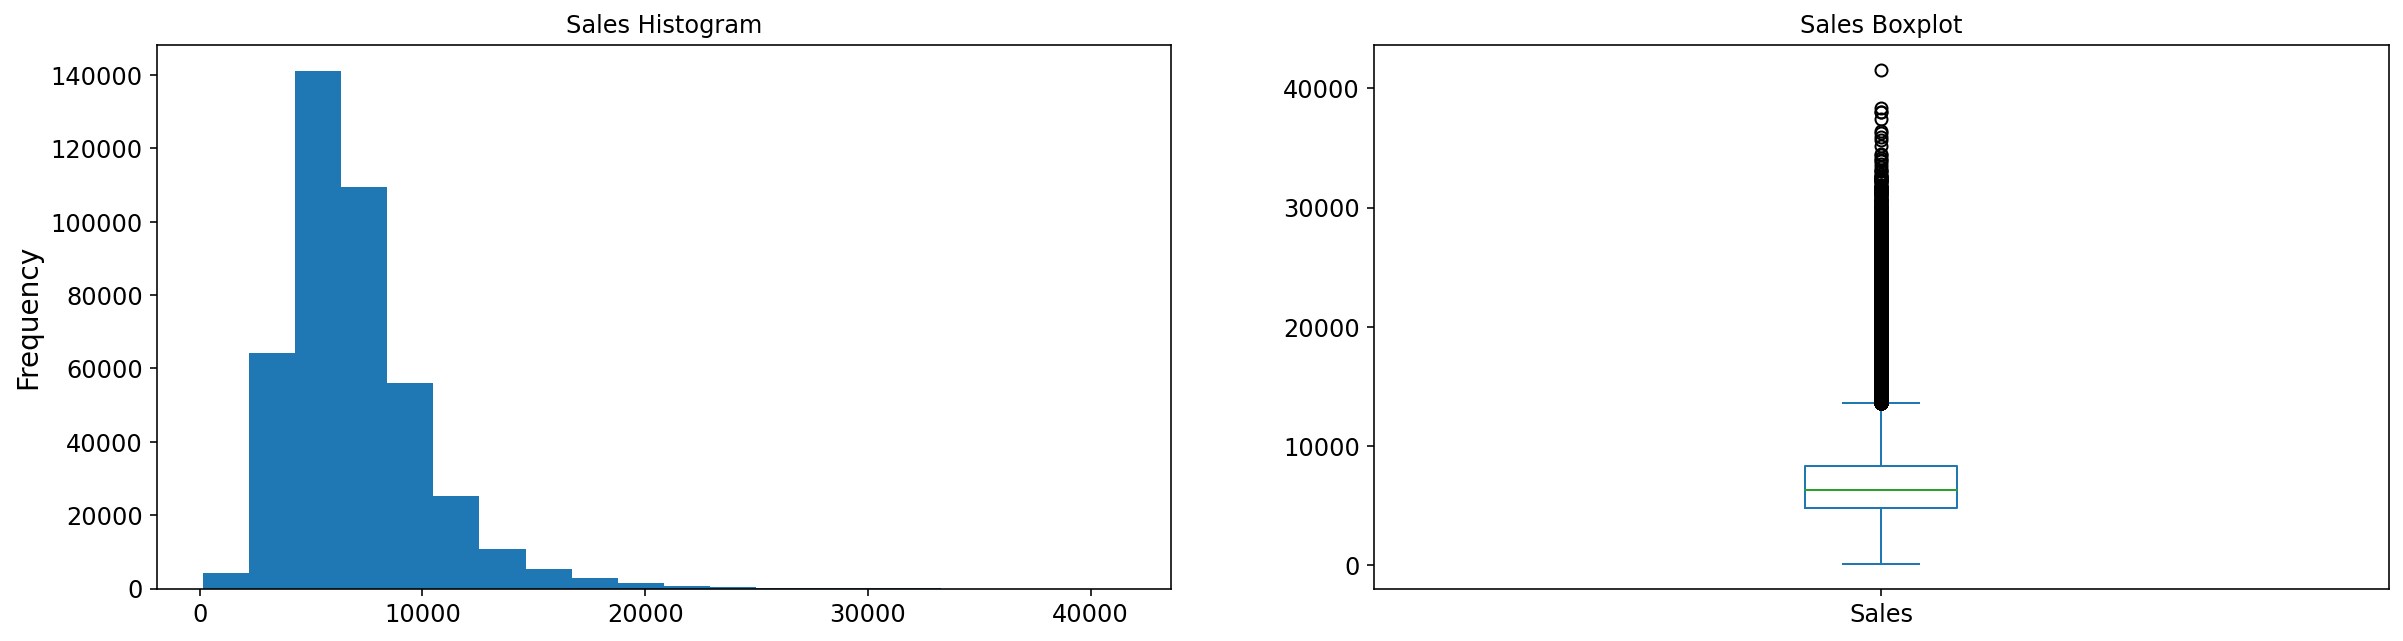

In [8]:
f, ax = plt.subplots(1,2, figsize = (20, 5))

opened_sales.Sales.plot(kind = "hist", title = "Sales Histogram", bins = 20, ax = ax[0])
opened_sales.Sales.plot.box(title = "Sales Boxplot", ax = ax[1])

In [9]:
print("Rossmann has", round(opened_sales.Sales[(opened_sales.Sales > 10000)].count() / opened_sales.shape[0] * 100, 2), 
      "% of the time big sales, over 10000 Euros")
print("Rossmann has", round(opened_sales.Sales[(opened_sales.Sales < 1000)].count() / opened_sales.shape[0] * 100, 4), 
      "% of the time low sales, under 1000 Euros")

Rossmann has 13.45 % of the time big sales, over 10000 Euros
Rossmann has 0.0277 % of the time low sales, under 1000 Euros


**Customers**

In [10]:
train_df.Customers.describe()


count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64

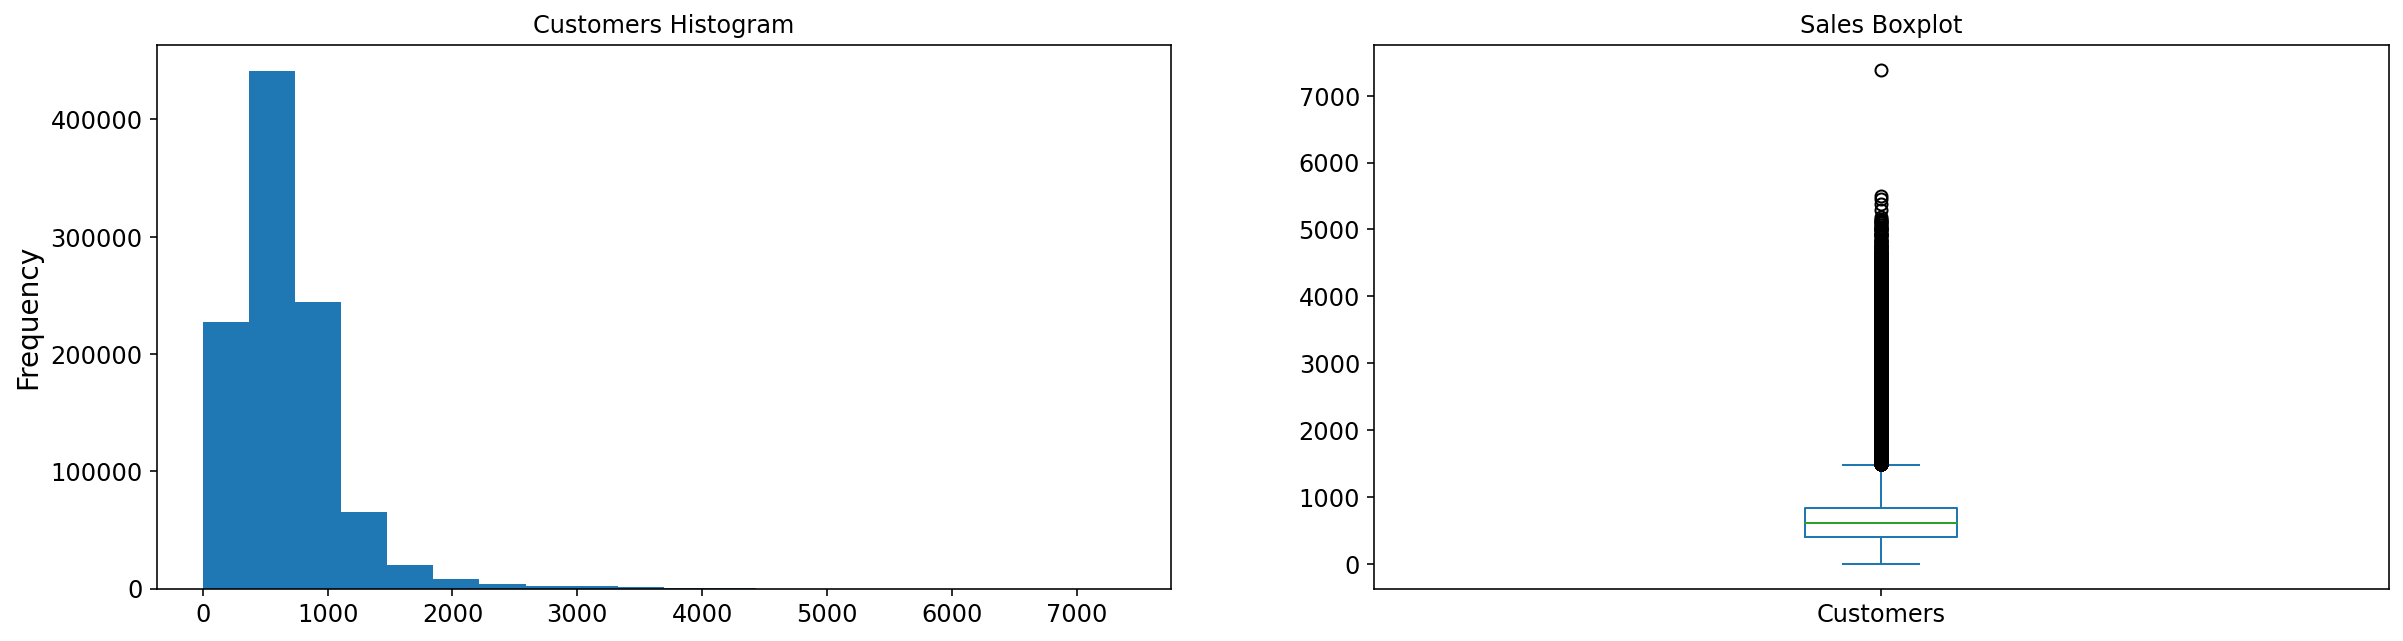

In [11]:
f, ax = plt.subplots(1,2, figsize = (20, 5))

train_df.Customers.plot(kind = "hist", title = "Customers Histogram", bins = 20, ax = ax[0])
train_df.Customers.plot.box(title = "Sales Boxplot", ax = ax[1])

In [12]:
#Seems to had a great sortiment on 22th of January 2013. They hit the record of customers. 
train_df[(train_df.Customers > 6000)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
993496,817,2,2013-01-22,27190,7388,1,1,0,0


**Open**

In [13]:
print("In 3 years, different stores where", train_df[(train_df.Open == 0)].count()[0], "times closed")
print("From this days,", train_df[(train_df.Open == 0) & 
         ((train_df.StateHoliday == "a") | 
         (train_df.StateHoliday == "b") | 
         (train_df.StateHoliday == "c"))].count()[0], "times the stores were closed because of holidays")
print(train_df[(train_df.Open == 0) & (train_df.SchoolHoliday == 1)].count()[0], "times, some stores were closed because of school holiday")
print("The stores were in some sundays opend ->", train_df[(train_df.Open == 1) & (train_df.DayOfWeek == 7)].count()[0], "times")
print("However,", train_df[(train_df.Open == 0) & ((train_df.StateHoliday == "0") | (train_df.StateHoliday == 0)) & (train_df.SchoolHoliday == 0)].count()[0], 
      "times, the stores were closed for no reason (No Holidays o Sunday)")

In 3 years, different stores where 172817 times closed
From this days, 30140 times the stores were closed because of holidays
18264 times, some stores were closed because of school holiday
The stores were in some sundays opend -> 3593 times
However, 139610 times, the stores were closed for no reason (No Holidays o Sunday)


**Promotion**

In [14]:
print(round((train_df.Promo[train_df.Promo == 1].count() / train_df.shape[0] * 100), 2), "% of the time, has been promotions made")


38.15 % of the time, has been promotions made


**StateHoliday**

In [15]:
# StateHoliday is not a continous number. 
train_df.StateHoliday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [16]:
# StateHoliday is a string and I for me is not so important to know what kind of holiday (a, b or c). I will convert it into 0 and 1, by creating a new variable
train_df["StateHoliday_cat"] = train_df["StateHoliday"].map({0:0, "0": 0, "a": 1, "b": 1, "c": 1})
train_df.StateHoliday_cat.count()

1017209

In [17]:
# let get rid of the StateHoliday column and use only the new one
train_df = train_df.drop("StateHoliday", axis = 1)
train_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_cat
1017204,1111,2,2013-01-01,0,0,0,0,1,1
1017205,1112,2,2013-01-01,0,0,0,0,1,1
1017206,1113,2,2013-01-01,0,0,0,0,1,1
1017207,1114,2,2013-01-01,0,0,0,0,1,1
1017208,1115,2,2013-01-01,0,0,0,0,1,1


**Store analysis**

In [18]:
store_df.head().append(store_df.tail())


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [19]:
#how may missing data do we have in %:
100- (store_df.count() / store_df.shape[0] * 100)

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.269058
CompetitionOpenSinceMonth    31.748879
CompetitionOpenSinceYear     31.748879
Promo2                        0.000000
Promo2SinceWeek              48.789238
Promo2SinceYear              48.789238
PromoInterval                48.789238
dtype: float64

In [20]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


**CompetitionDistance**

the median is 2325.0 and mean is 5404.901079136691


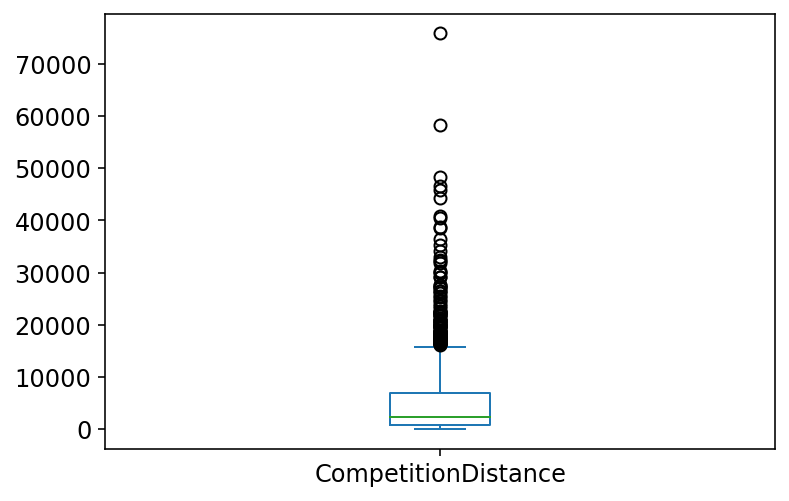

In [21]:
store_df.CompetitionDistance.plot.box() #let me see the outliers, so we can choose between mean and median to fill the NaNs
print("the median is", store_df.CompetitionDistance.median(), "and mean is", store_df.CompetitionDistance.mean())

In [22]:
print("Since we have here some outlier, its better to input the median value to those few missing values.")
store_df["CompetitionDistance"].fillna(store_df["CompetitionDistance"].median(), inplace = True)

Since we have here some outlier, its better to input the median value to those few missing values.


**CompetitionOpenSinceMonth and CompetitionOpenSinceYear.**

In [23]:
#The missing values, are not there, because the stores had no competition. So I would suggest to fill the missing values with zeros.
store_df["CompetitionOpenSinceMonth"].fillna(0, inplace = True)
store_df["CompetitionOpenSinceYear"].fillna(0, inplace = True)

In [24]:
store_df.groupby(by = "Promo2", axis = 0).count() 


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Promo2,,,,,,,,,
0,544,544,544,544,544,544,0,0,0
1,571,571,571,571,571,571,571,571,571


In [25]:
# so if no promo has been made, then we should replace the NaN from Promo since Week and Year with zero
store_df["Promo2SinceWeek"].fillna(0, inplace = True)
store_df["Promo2SinceYear"].fillna(0, inplace = True)
store_df["PromoInterval"].fillna(0, inplace = True)

store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


**merge the files: stores and training**

In [26]:
train_store_df = pd.merge(train_df, store_df, how = "left", on = "Store")
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   SchoolHoliday              1017209 non-null  int64  
 8   StateHoliday_cat           1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  1017209 non-null  float64
 13  CompetitionO

**store types**

In [27]:
train_store_df["Avg_Customer_Sales"] = train_store_df.Sales / train_store_df.Customers


In [28]:
train_store_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
SchoolHoliday                     0
StateHoliday_cat                  0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
PromoInterval                     0
Avg_Customer_Sales           172869
dtype: int64

In [29]:
train_store_df.dropna(inplace=True)

In [30]:
train_store_df.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
SchoolHoliday                0
StateHoliday_cat             0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
Avg_Customer_Sales           0
dtype: int64

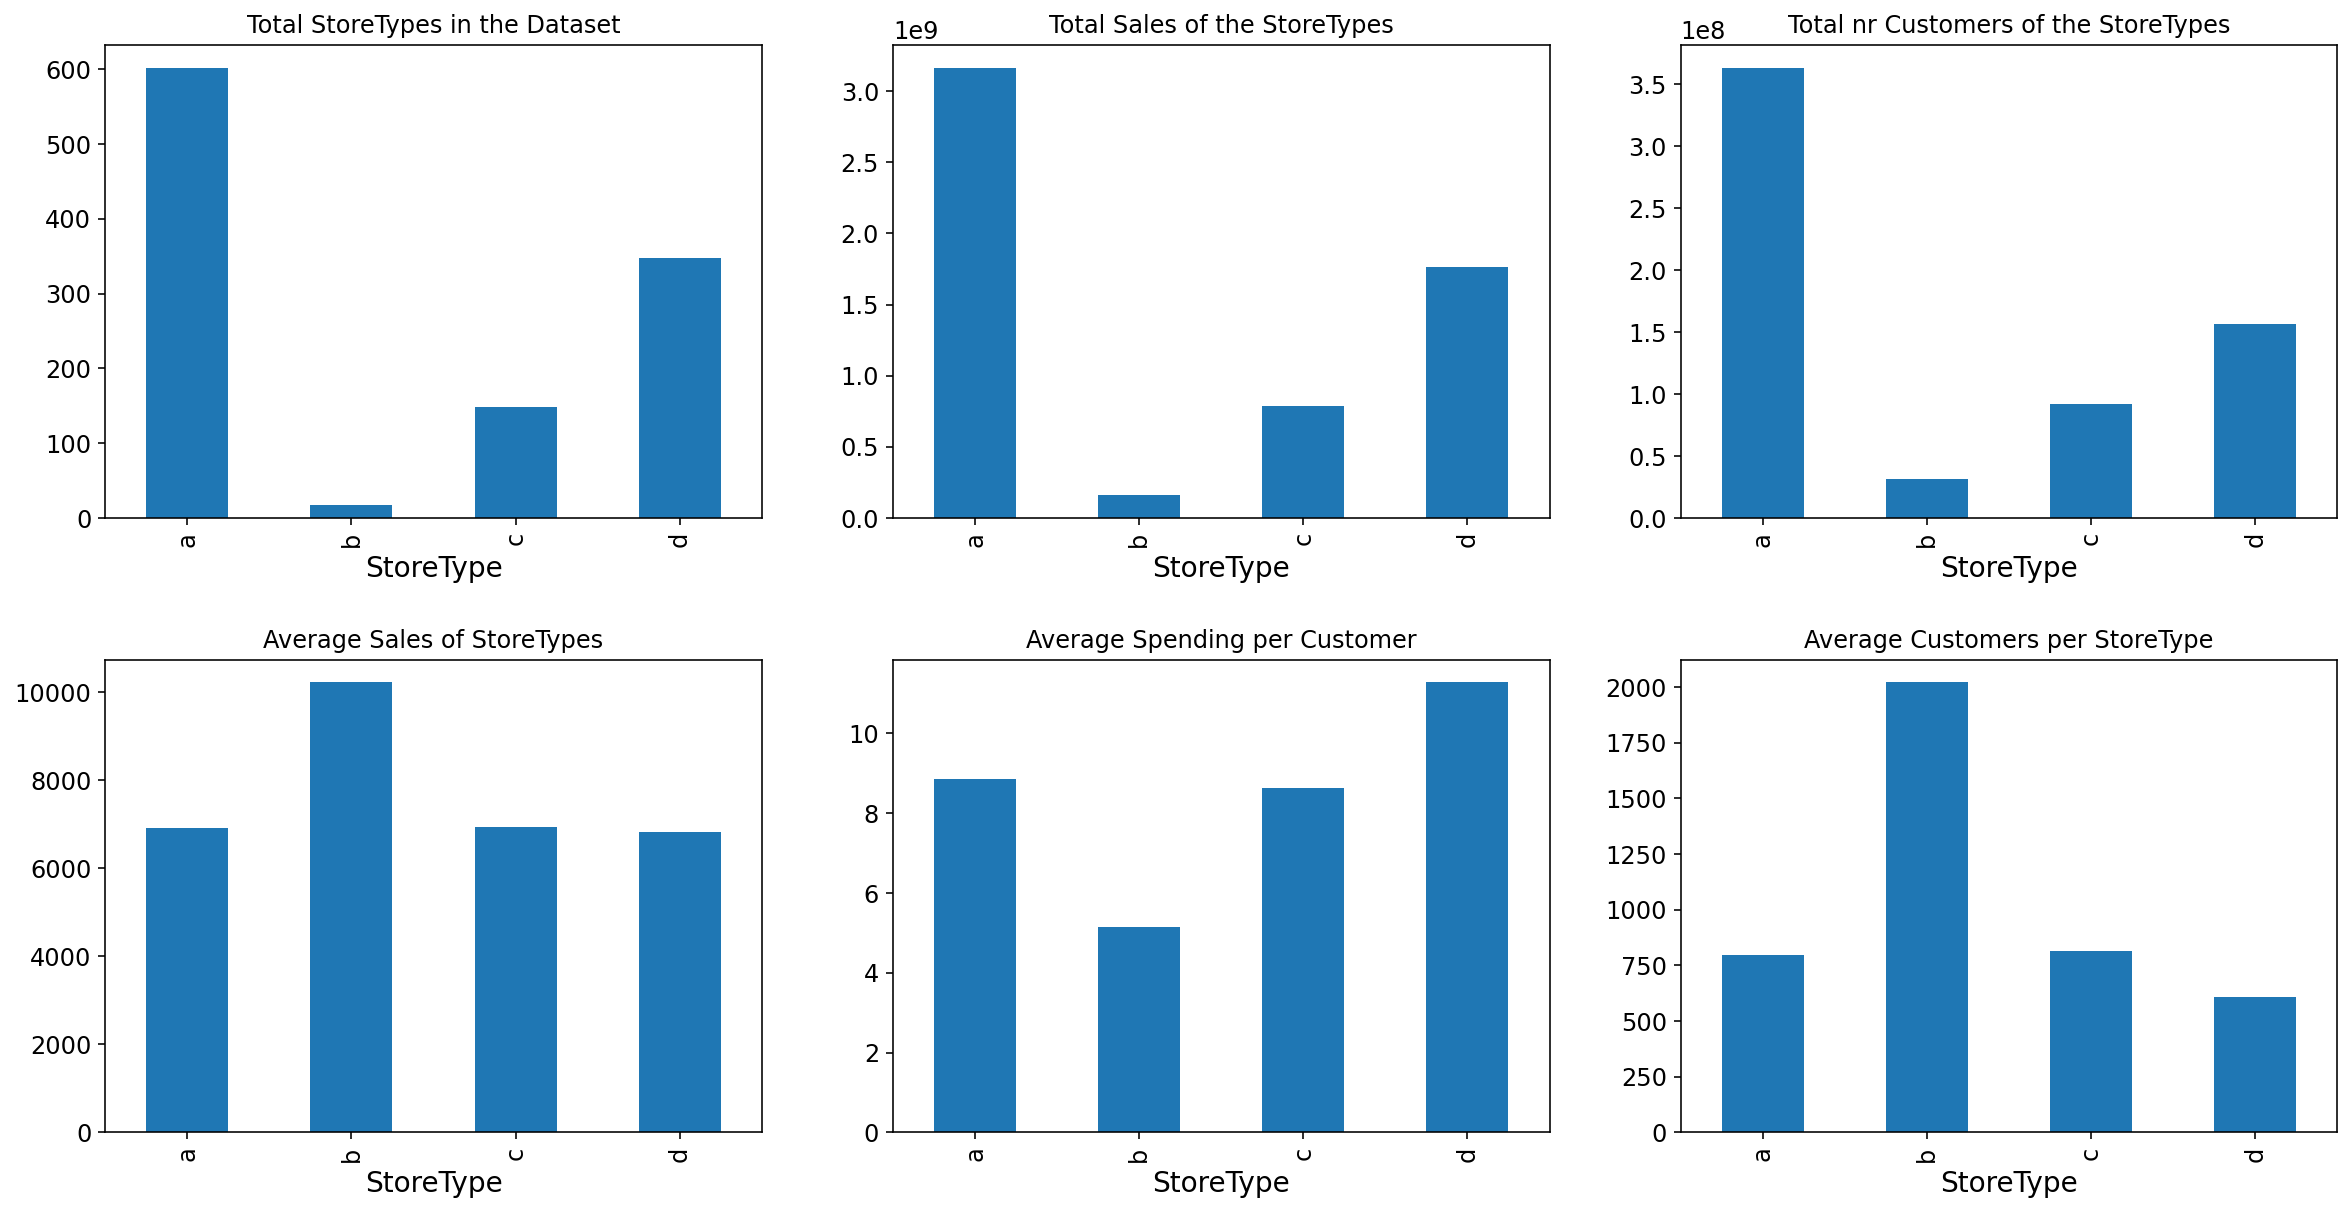

In [31]:
f, ax = plt.subplots(2, 3, figsize = (20,10))

store_df.groupby("StoreType")["Store"].count().plot(kind = "bar", ax = ax[0, 0], title = "Total StoreTypes in the Dataset")
train_store_df.groupby("StoreType")["Sales"].sum().plot(kind = "bar", ax = ax[0,1], title = "Total Sales of the StoreTypes")
train_store_df.groupby("StoreType")["Customers"].sum().plot(kind = "bar", ax = ax[0,2], title = "Total nr Customers of the StoreTypes")
train_store_df.groupby("StoreType")["Sales"].mean().plot(kind = "bar", ax = ax[1,0], title = "Average Sales of StoreTypes")
train_store_df.groupby("StoreType")["Avg_Customer_Sales"].mean().plot(kind = "bar", ax = ax[1,1], title = "Average Spending per Customer")
train_store_df.groupby("StoreType")["Customers"].mean().plot(kind = "bar", ax = ax[1,2], title = "Average Customers per StoreType")

plt.subplots_adjust(hspace = 0.3)
plt.show()

As we can see from the graphs, the StoreType A has the most stores, sales and customers. However the StoreType D has the best averages spendings per customers. StoreType B, with only 17 stores has the most average customers.

**Assortments**

So only the StoreType B has all assortments. I think thats why they are performing so good. Maybe this StoreType has more sales area.
      The assortment C is a good one, because the StoreType D has the best average customer spending.


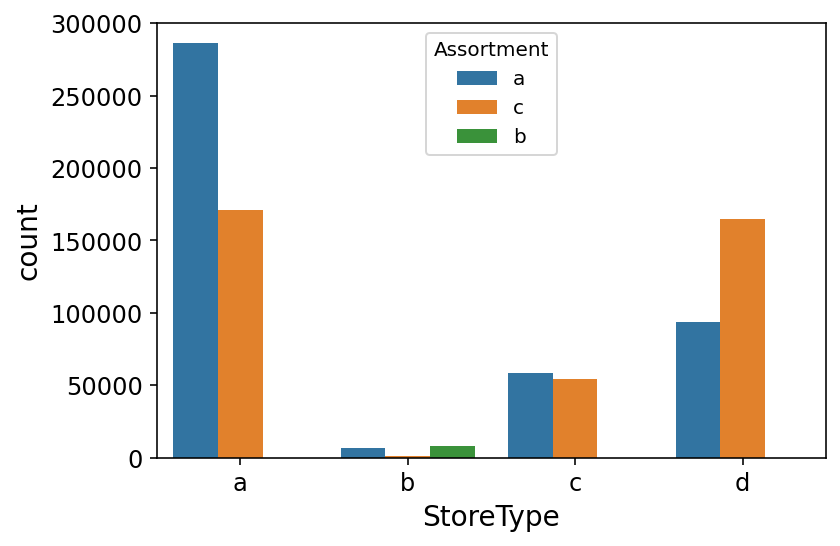

In [32]:
sns.countplot(data = train_store_df, x = "StoreType", hue = "Assortment", order=["a","b","c","d"]) 
print("""So only the StoreType B has all assortments. I think thats why they are performing so good. Maybe this StoreType has more sales area.
      The assortment C is a good one, because the StoreType D has the best average customer spending.""")

plt.show()

**Promotions**

In [33]:
train_store_df.Date = train_store_df.Date.astype("datetime64[ns]")

train_store_df["Month"] = train_store_df.Date.dt.month
train_store_df["Year"] = train_store_df.Date.dt.year
train_store_df["Day"] = train_store_df.Date.dt.day

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


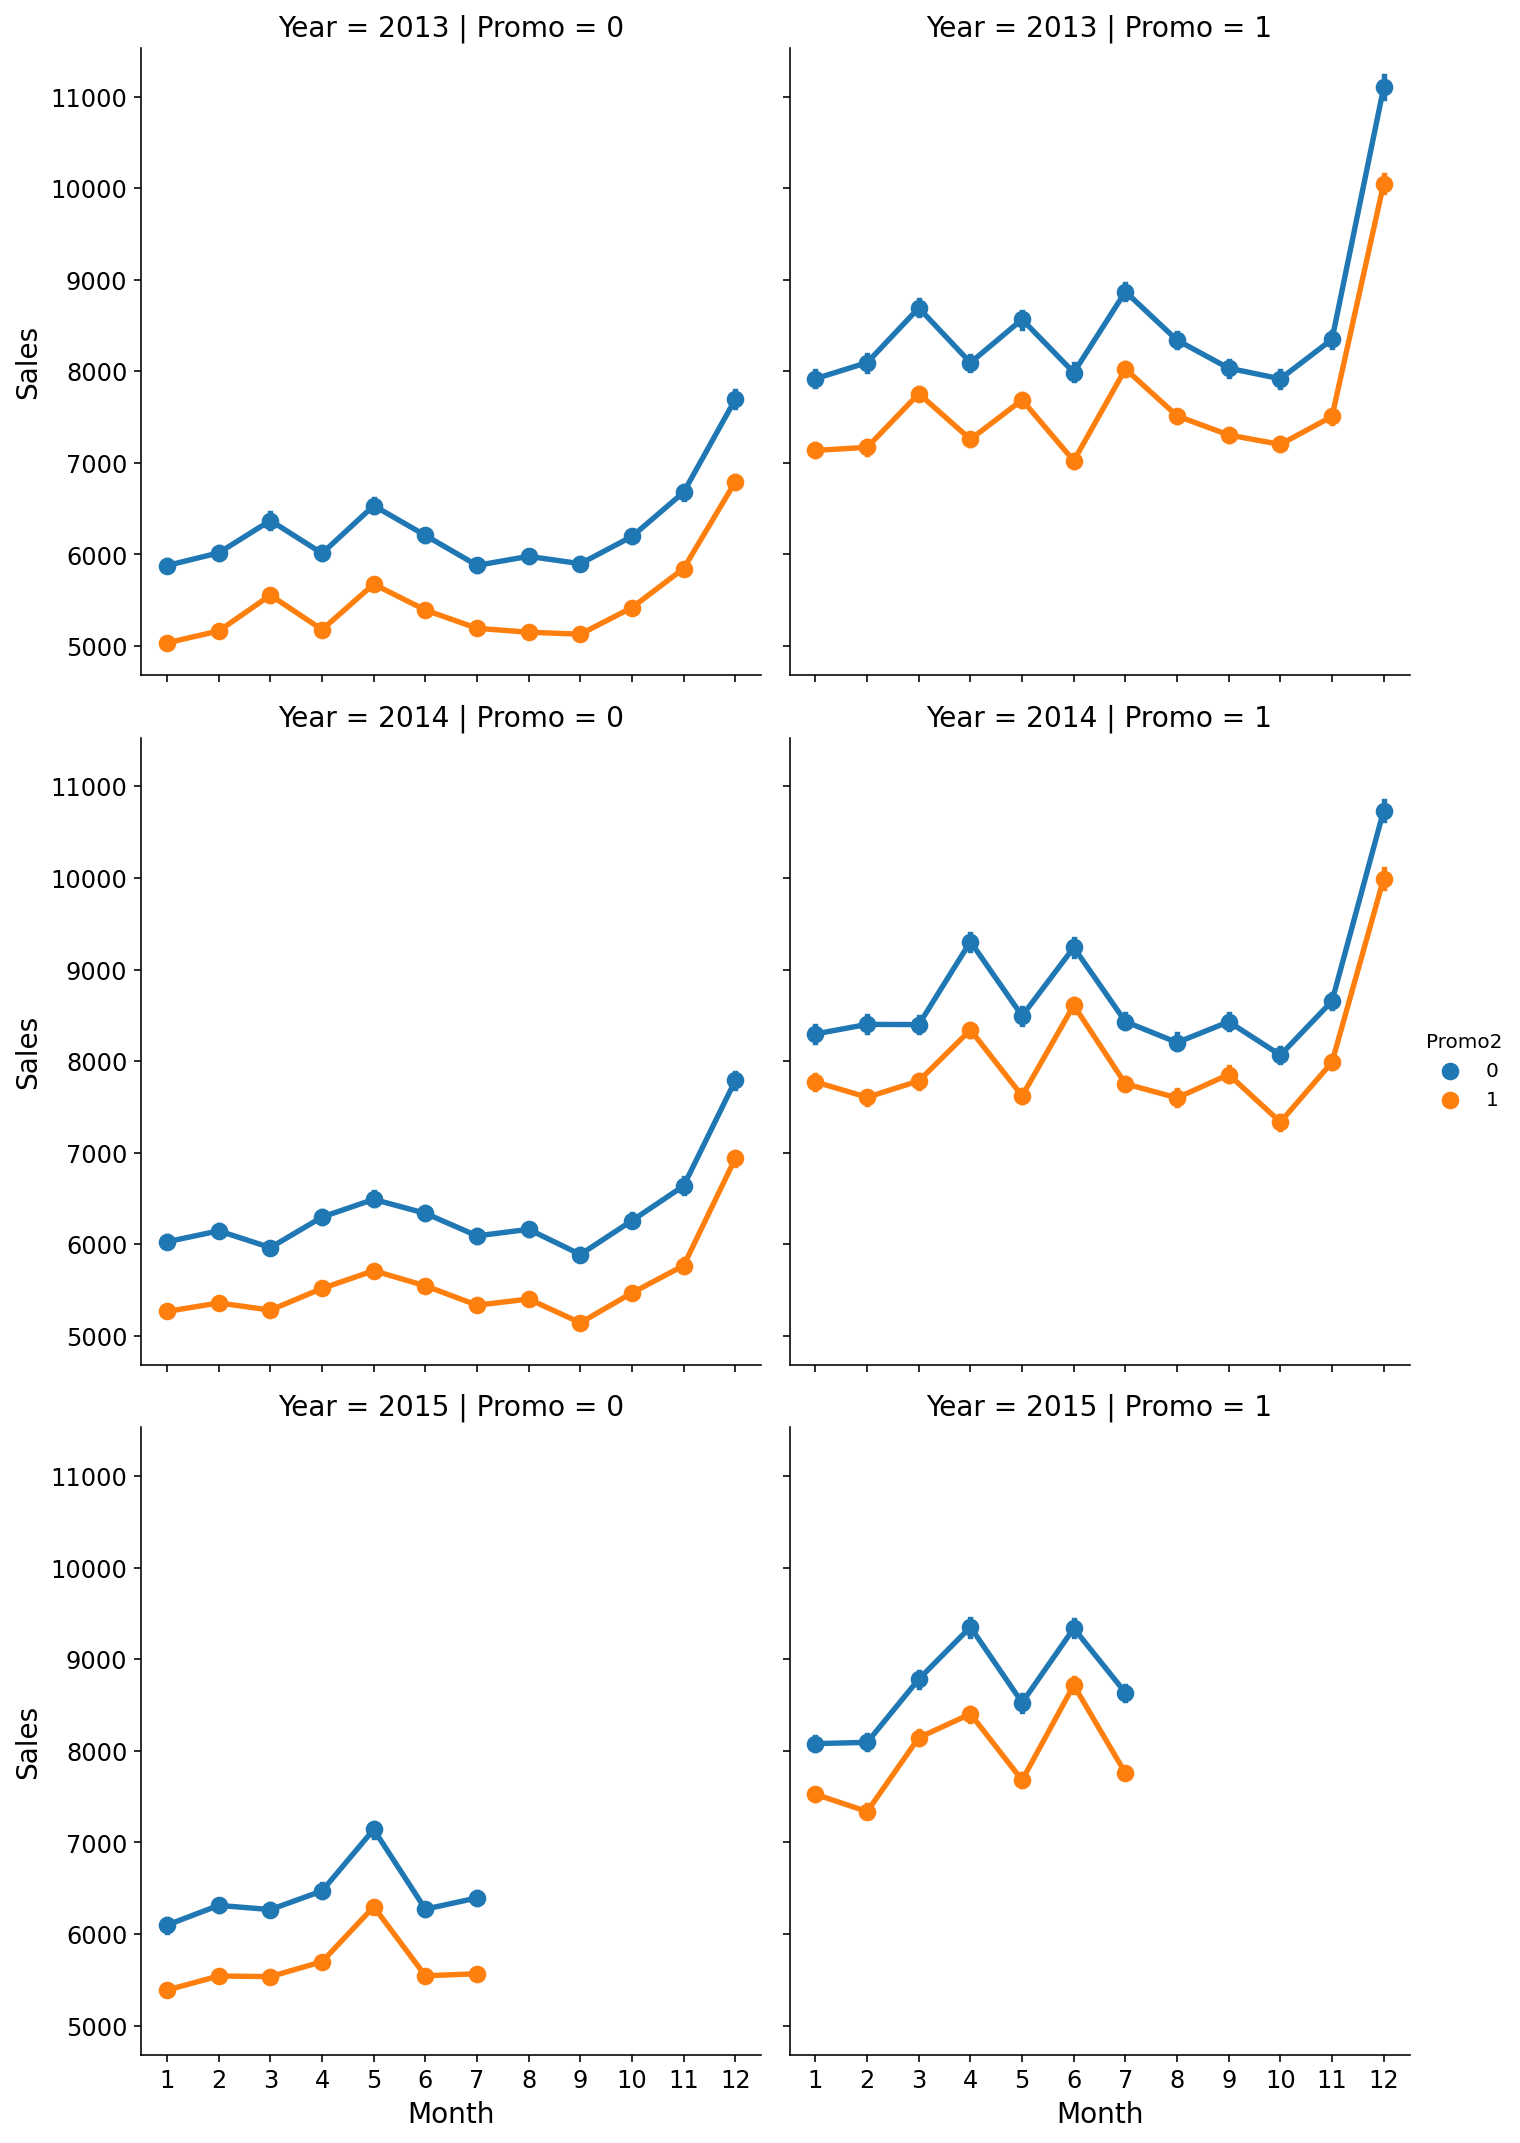

In [34]:
sns.factorplot(data = train_store_df, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year"
             )
# So, of course, if the stores are having promotion the sells are higher.
# Overall the store promotions sellings are also higher than the seasionality promotions (Promo2). However I can't see no yearly trend. 

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


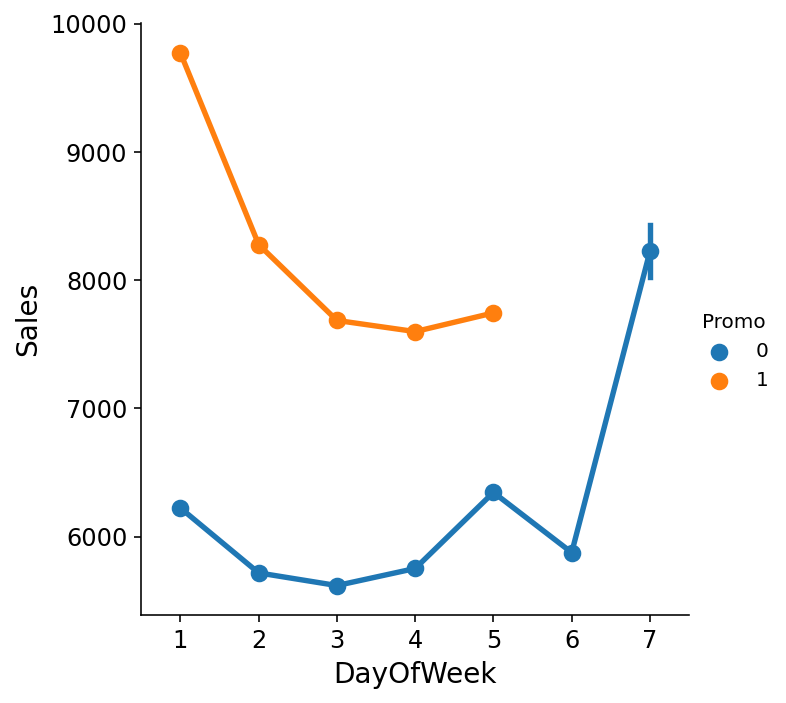

In [35]:
sns.factorplot(data = train_store_df, x = "DayOfWeek", y = "Sales", hue = "Promo")


**Competition Distance**

In [36]:
train_store_df.CompetitionDistance.describe()
# The obsverations are continous numbers, so we need to convert them into a categories. Lets a create a new variable.
train_store_df["CompetitionDistance_Cat"] = pd.cut(train_store_df["CompetitionDistance"], 5)

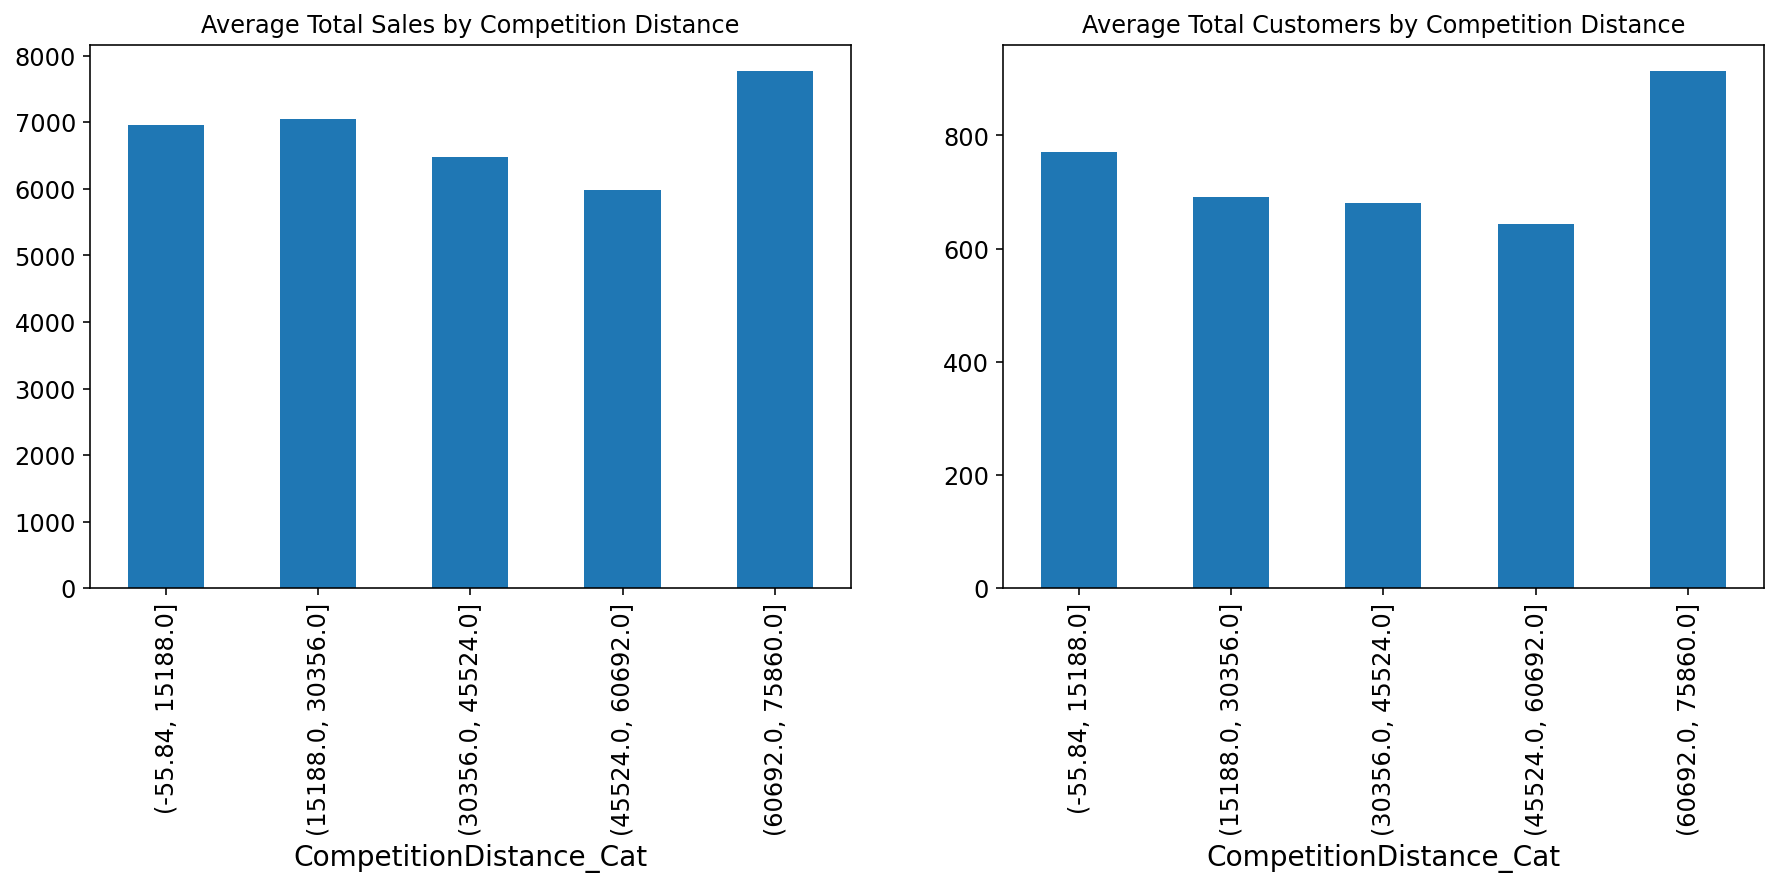

In [37]:
f, ax = plt.subplots(1,2, figsize = (15,5))

train_store_df.groupby(by = "CompetitionDistance_Cat").Sales.mean().plot(kind = "bar", title = "Average Total Sales by Competition Distance", ax = ax[0])
train_store_df.groupby(by = "CompetitionDistance_Cat").Customers.mean().plot(kind = "bar", title = "Average Total Customers by Competition Distance", ax = ax[1])

# It is pretty clear. If the competions is very far away, the stores are performing better (sales and customers)

In [38]:
# first we have to convert the variables to categories, bevor we convert them to codes.

# train_store_df["Promo"] = train_store_df["Promo"].astype("category") # it's already numerica
# train_store_df["SchoolHoliday"] = train_store_df["SchoolHoliday"].astype("category") # it's already numerica
train_store_df["StoreType"] = train_store_df["StoreType"].astype("category")
train_store_df["Assortment"] = train_store_df["Assortment"].astype("category")
# train_store_df["Promo2"] = train_store_df["Promo2"].astype("category") # it's already numerica
train_store_df["PromoInterval"] = train_store_df["PromoInterval"].astype("category")

train_store_df["StoreType_cat"] = train_store_df["StoreType"].cat.codes
train_store_df["Assortment_cat"] = train_store_df["Assortment"].cat.codes
train_store_df["PromoInterval_cat"] = train_store_df["Assortment"].cat.codes

train_store_df["StateHoliday_cat"] = train_store_df["StateHoliday_cat"].astype("float")
train_store_df["StoreType_cat"] = train_store_df["StoreType_cat"].astype("float")
train_store_df["Assortment_cat"] = train_store_df["Assortment_cat"].astype("float")
train_store_df["PromoInterval_cat"] = train_store_df["PromoInterval_cat"].astype("float")

In [39]:
train_store_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 844340 entries, 0 to 1017190
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844340 non-null  int64         
 1   DayOfWeek                  844340 non-null  int64         
 2   Date                       844340 non-null  datetime64[ns]
 3   Sales                      844340 non-null  int64         
 4   Customers                  844340 non-null  int64         
 5   Open                       844340 non-null  int64         
 6   Promo                      844340 non-null  int64         
 7   SchoolHoliday              844340 non-null  int64         
 8   StateHoliday_cat           844340 non-null  float64       
 9   StoreType                  844340 non-null  category      
 10  Assortment                 844340 non-null  category      
 11  CompetitionDistance        844340 non-null  float64

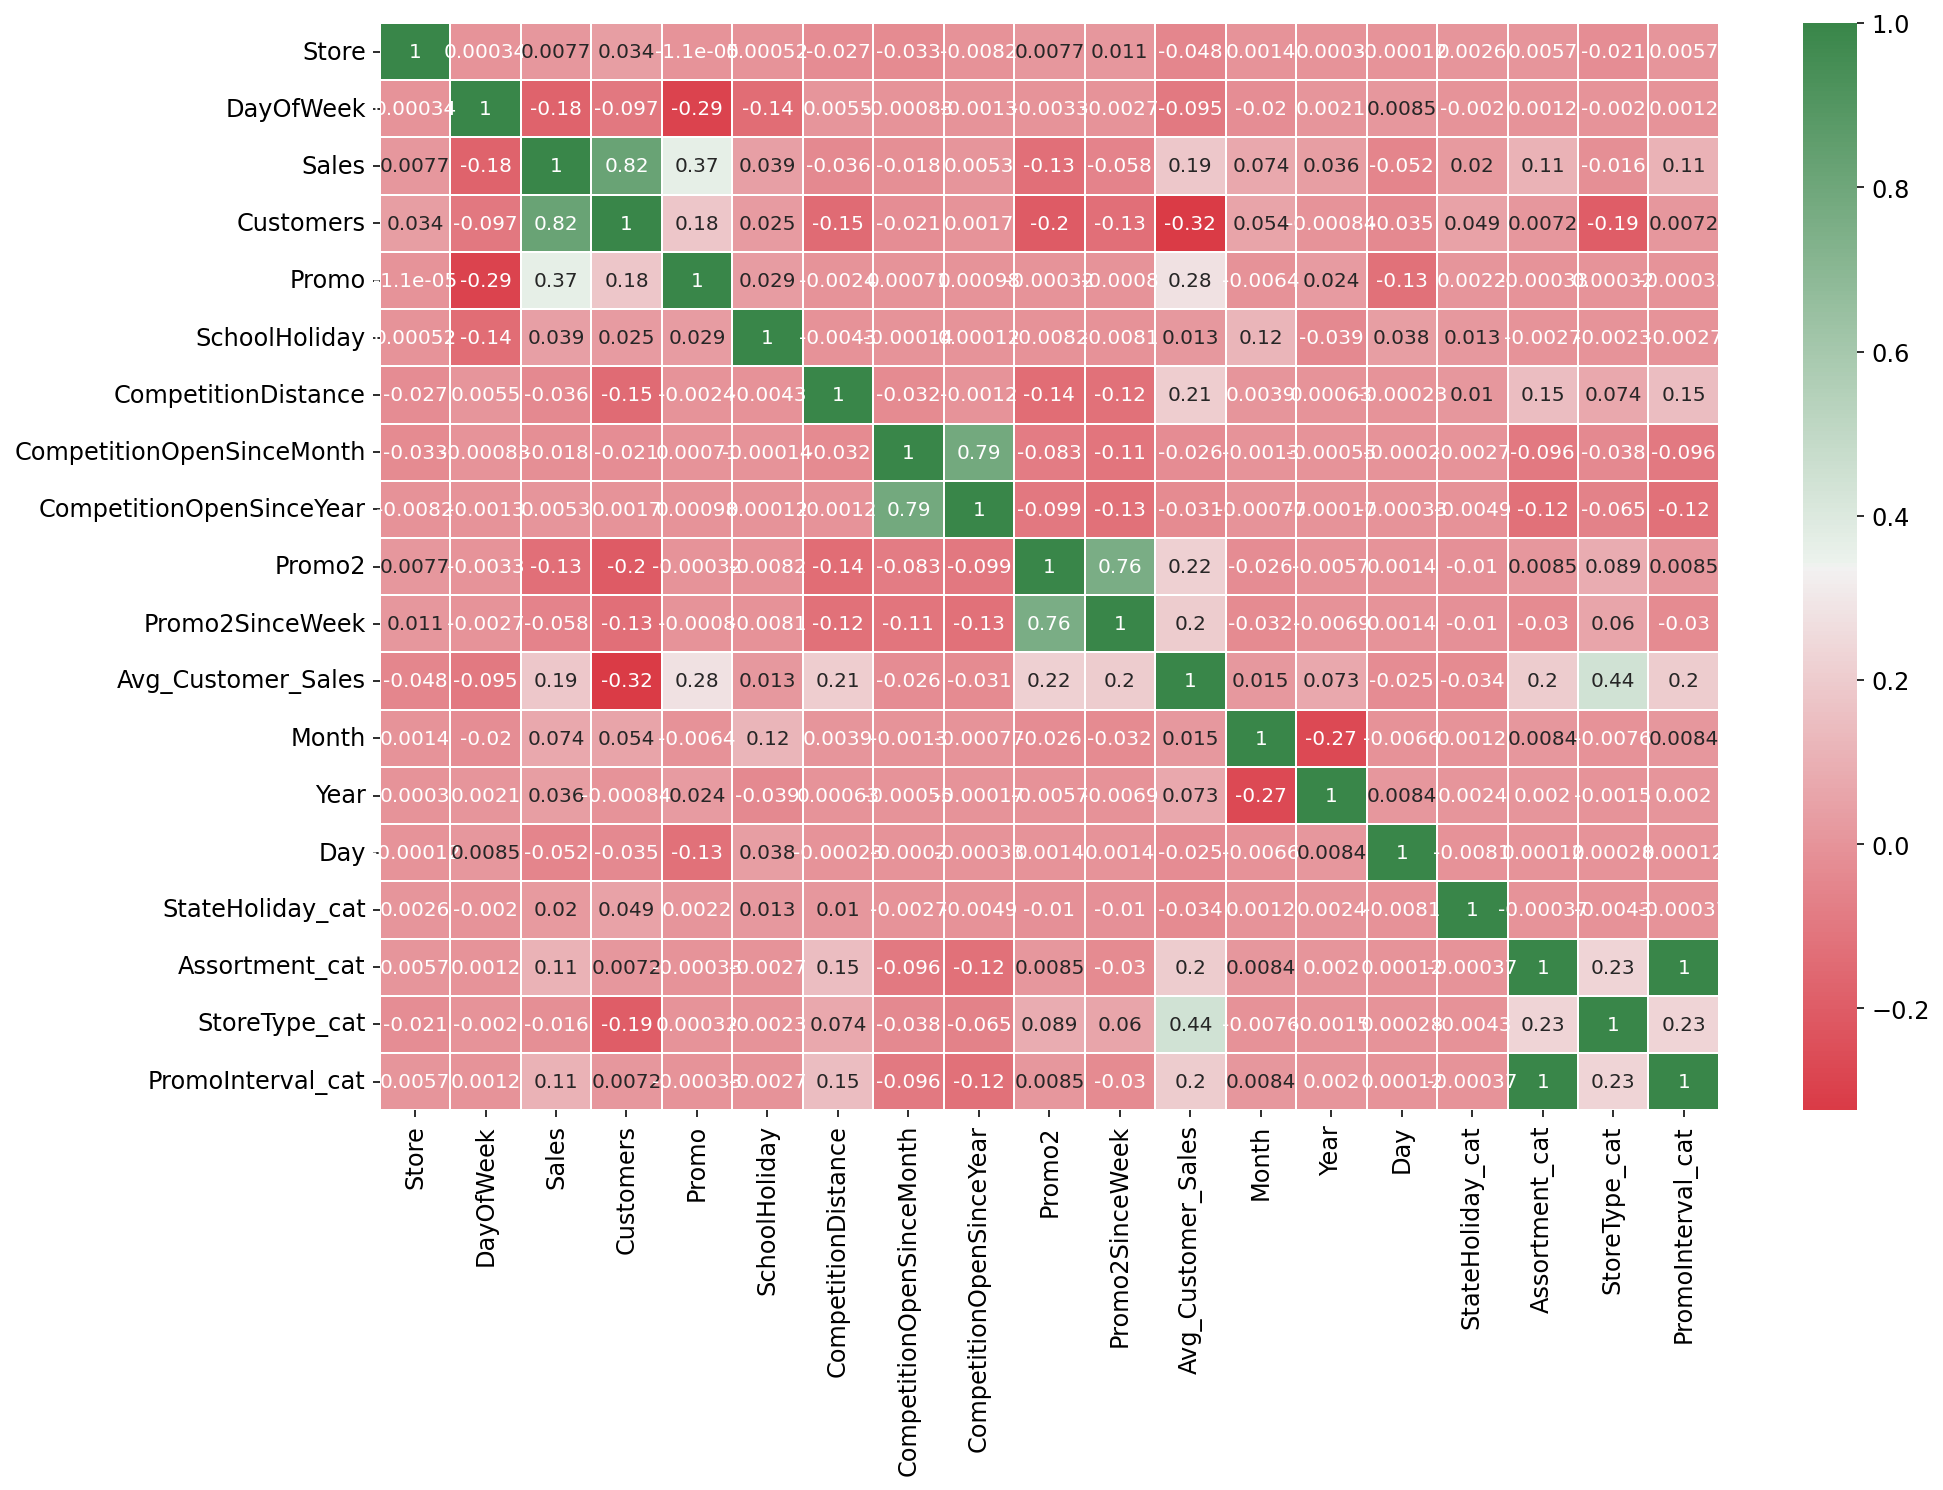

In [40]:

df_correlation = train_store_df[["Store", "DayOfWeek", "Sales", "Customers", "Promo", "SchoolHoliday", "CompetitionDistance", 
                                 "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2", "Promo2SinceWeek", "Avg_Customer_Sales", 
                                 "Month", "Year", "Day", "StateHoliday_cat", "Assortment_cat", "StoreType_cat", "PromoInterval_cat"]]


f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(df_correlation.corr(),ax = ax, annot=True, cmap=sns.diverging_palette(10, 133, as_cmap=True), linewidths=0.5)

Following correlations we can confirm from the graph above:

 - Customer vs Sales (0.82)
 - Promo vs Sales (0.37)
 - Avg_Customer_Sales vs Promo (0.28)
 - Avg_Customer_Sales vs Promo2 (0.22)
 - StoreTypve vs Avg_Customer_Sales (0.44)

My conclusion of the analysis:
 - StoreType A has the most sells and customers.
 - StoreType B has the lowest Average Sales per Customer. So i think customers visit this type only for small things.
 - StoreTybe D had the highest buyer cart.
 - Promo runs only in weekdays.
 - Promo2 doesnt seems to be correlated to any significant change in the sales amount.
 - Customers tends to buy more on Monday, when there's promotion running (Promo) and on Sundays, when there is no promotion at all.
 - At this point, I dont see any yearly trends. Only seasonal patterns.

**FBProphet**

In [41]:
from fbprophet import Prophet

In [42]:
# I want to create a new dataframe for this model.
ts_prophet = train_store_df.drop(['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo',
       'StoreType', 'Assortment',
       'CompetitionDistance', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear',
       'PromoInterval', 'Avg_Customer_Sales', 'Month', 'Year', 'Day',
       'CompetitionDistance_Cat', 'StoreType_cat', 'Assortment_cat',
       'PromoInterval_cat', "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)

ts_prophet.head()

,Date,Sales,SchoolHoliday,StateHoliday_cat
0,2015-07-31,5263,1,0.0
1,2015-07-31,6064,1,0.0
2,2015-07-31,8314,1,0.0
3,2015-07-31,13995,1,0.0
4,2015-07-31,4822,1,0.0


In [43]:
# as I understand from the documentation, the variables should have a specific names
ts_prophet = ts_prophet.rename(columns = {"Date": "ds",
                          "Sales": "y"})

ts_prophet.tail()

,ds,y,SchoolHoliday,StateHoliday_cat
1016776,2013-01-01,3375,1,1.0
1016827,2013-01-01,10765,1,1.0
1016863,2013-01-01,5035,1,1.0
1017042,2013-01-01,4491,1,1.0
1017190,2013-01-01,5961,1,1.0


In [44]:
# In prophet we can also model the holidays. so lets go for it.

state_dates = ts_prophet[(ts_prophet.StateHoliday_cat == 1)].loc[:, "ds"].values
school_dates = ts_prophet[(ts_prophet.SchoolHoliday == 1)].loc[:, "ds"].values

state = pd.DataFrame({"holiday": "state_holiday", 
                     "ds": pd.to_datetime(state_dates)})
school = pd.DataFrame({"holiday": "school_holiday",
                      "ds": pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [45]:
ts_prophet = ts_prophet.drop(["SchoolHoliday", "StateHoliday_cat"], axis = 1) # we dont need them anymore.


In [46]:
# it takes just too long to fit the model with a daily time series, so lets make it weekly.
ts_week_prophet = ts_prophet.set_index("ds").resample("W").sum()
ts_week_prophet_train = ts_week_prophet["2013-01-01": "2015-01-11"] #I will slice the dataframe, so we can have some testing data 
ts_week_prophet_train = ts_week_prophet_train.reset_index()
ts_week_prophet = ts_week_prophet.reset_index() # here are all the weekly data

holidays_week = holidays.set_index("ds").resample("W").min()
holidays_week = holidays_week.dropna(axis = 0)
# holidays_week.holiday.fillna(0, inplace = True)
holidays_week = holidays_week.reset_index()

In [47]:
# lets fit the model
prophet = Prophet(holidays = holidays) # holidays = holidays_week
# prophet = Prophet(interval_width = 0.80, holidays = holidays, weekly_seasonality=True, daily_seasonality=False) # the default uncertainty is 80 %
prophet.fit(ts_week_prophet_train)
print("done")

future = prophet.make_future_dataframe(periods = 52, freq = "W") # here we are extending our dataframe with the dates for which a prediction is to be made.
forecast = prophet.predict(future) # with predict method I asign each row in future dates a predicted value, which it names yhat

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail() # We have a new dataframe, which includes, the forecast and the uncertainity invervals.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


done


,ds,yhat,yhat_lower,yhat_upper
153,2015-12-13,5.020584e+07,4.121142e+07,5.993182e+07
154,2015-12-20,4.823195e+07,3.906990e+07,5.700101e+07
155,2015-12-27,4.308716e+07,3.360609e+07,5.243201e+07
156,2016-01-03,3.830047e+07,2.917293e+07,4.728695e+07
157,2016-01-10,3.653743e+07,2.701555e+07,4.613664e+07


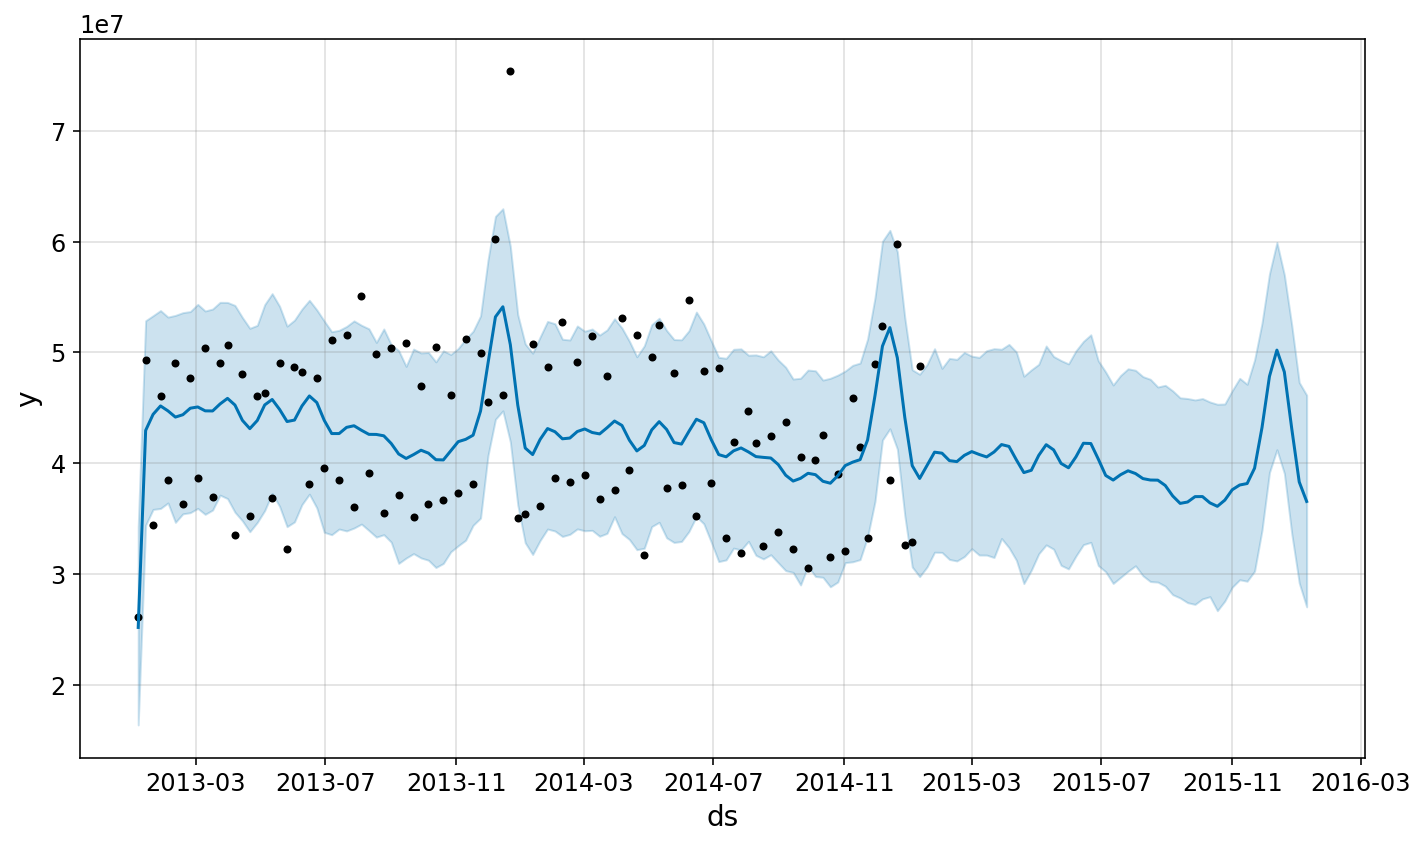

In [48]:
fig1 = prophet.plot(forecast) #plot the results for the forecast time.


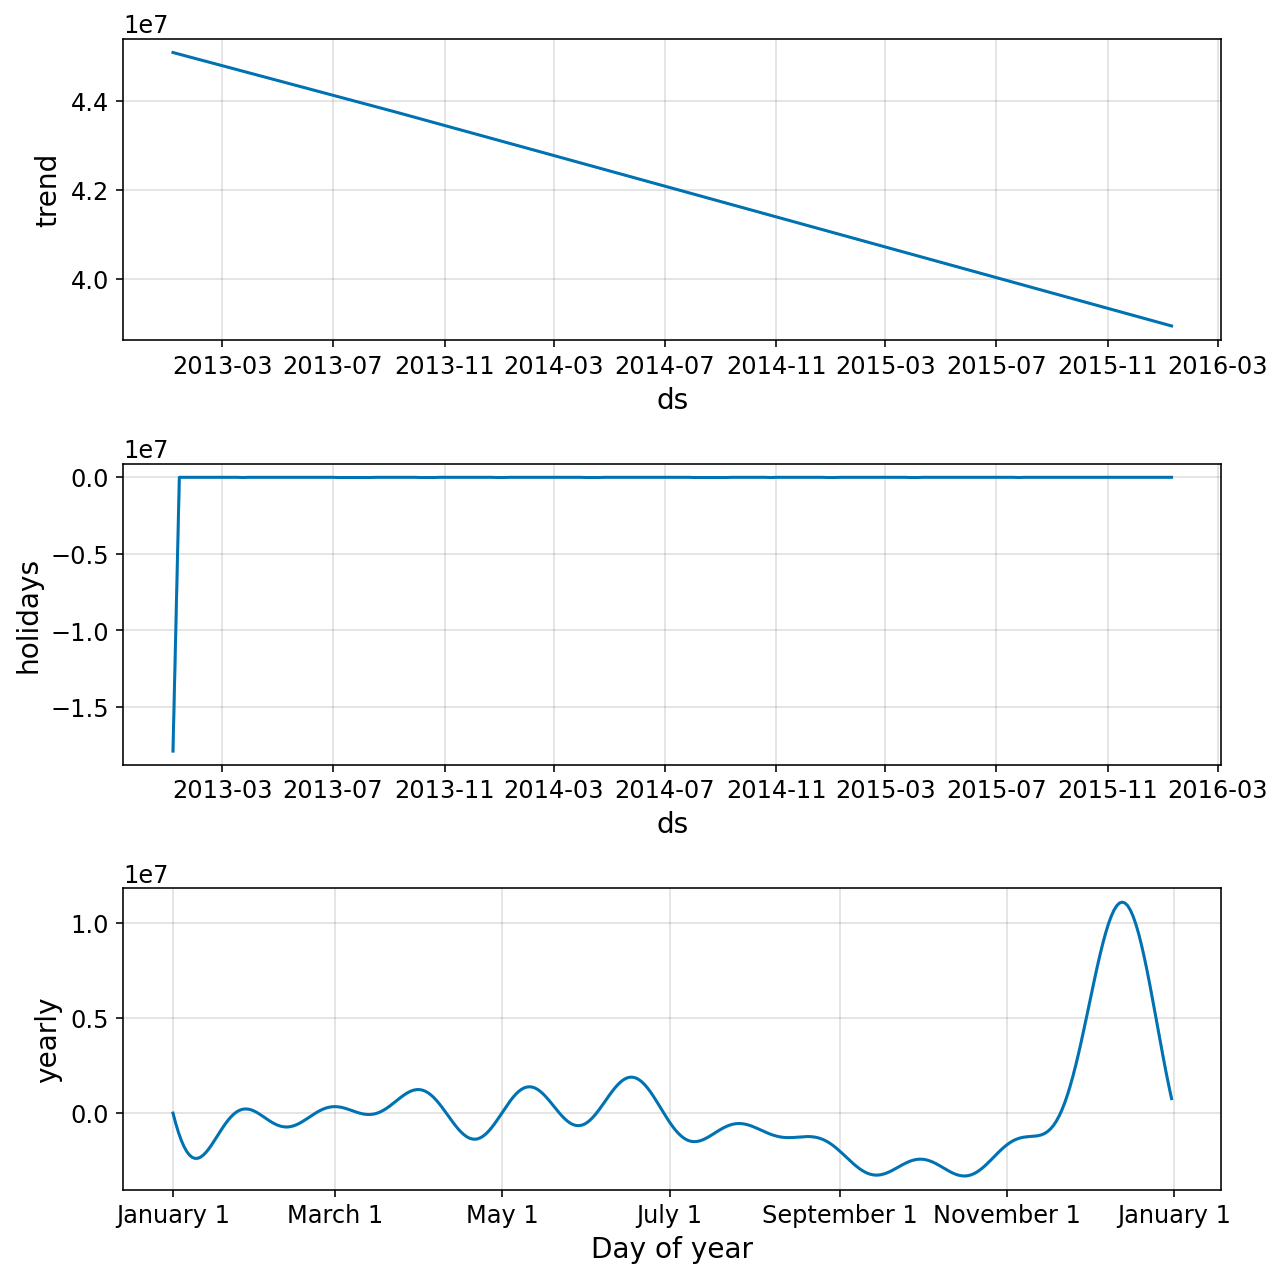

In [49]:
# with this method we can see the components (trend, yearly seasonality and weekly seasonality of the time series.).
fig2 = prophet.plot_components(forecast)

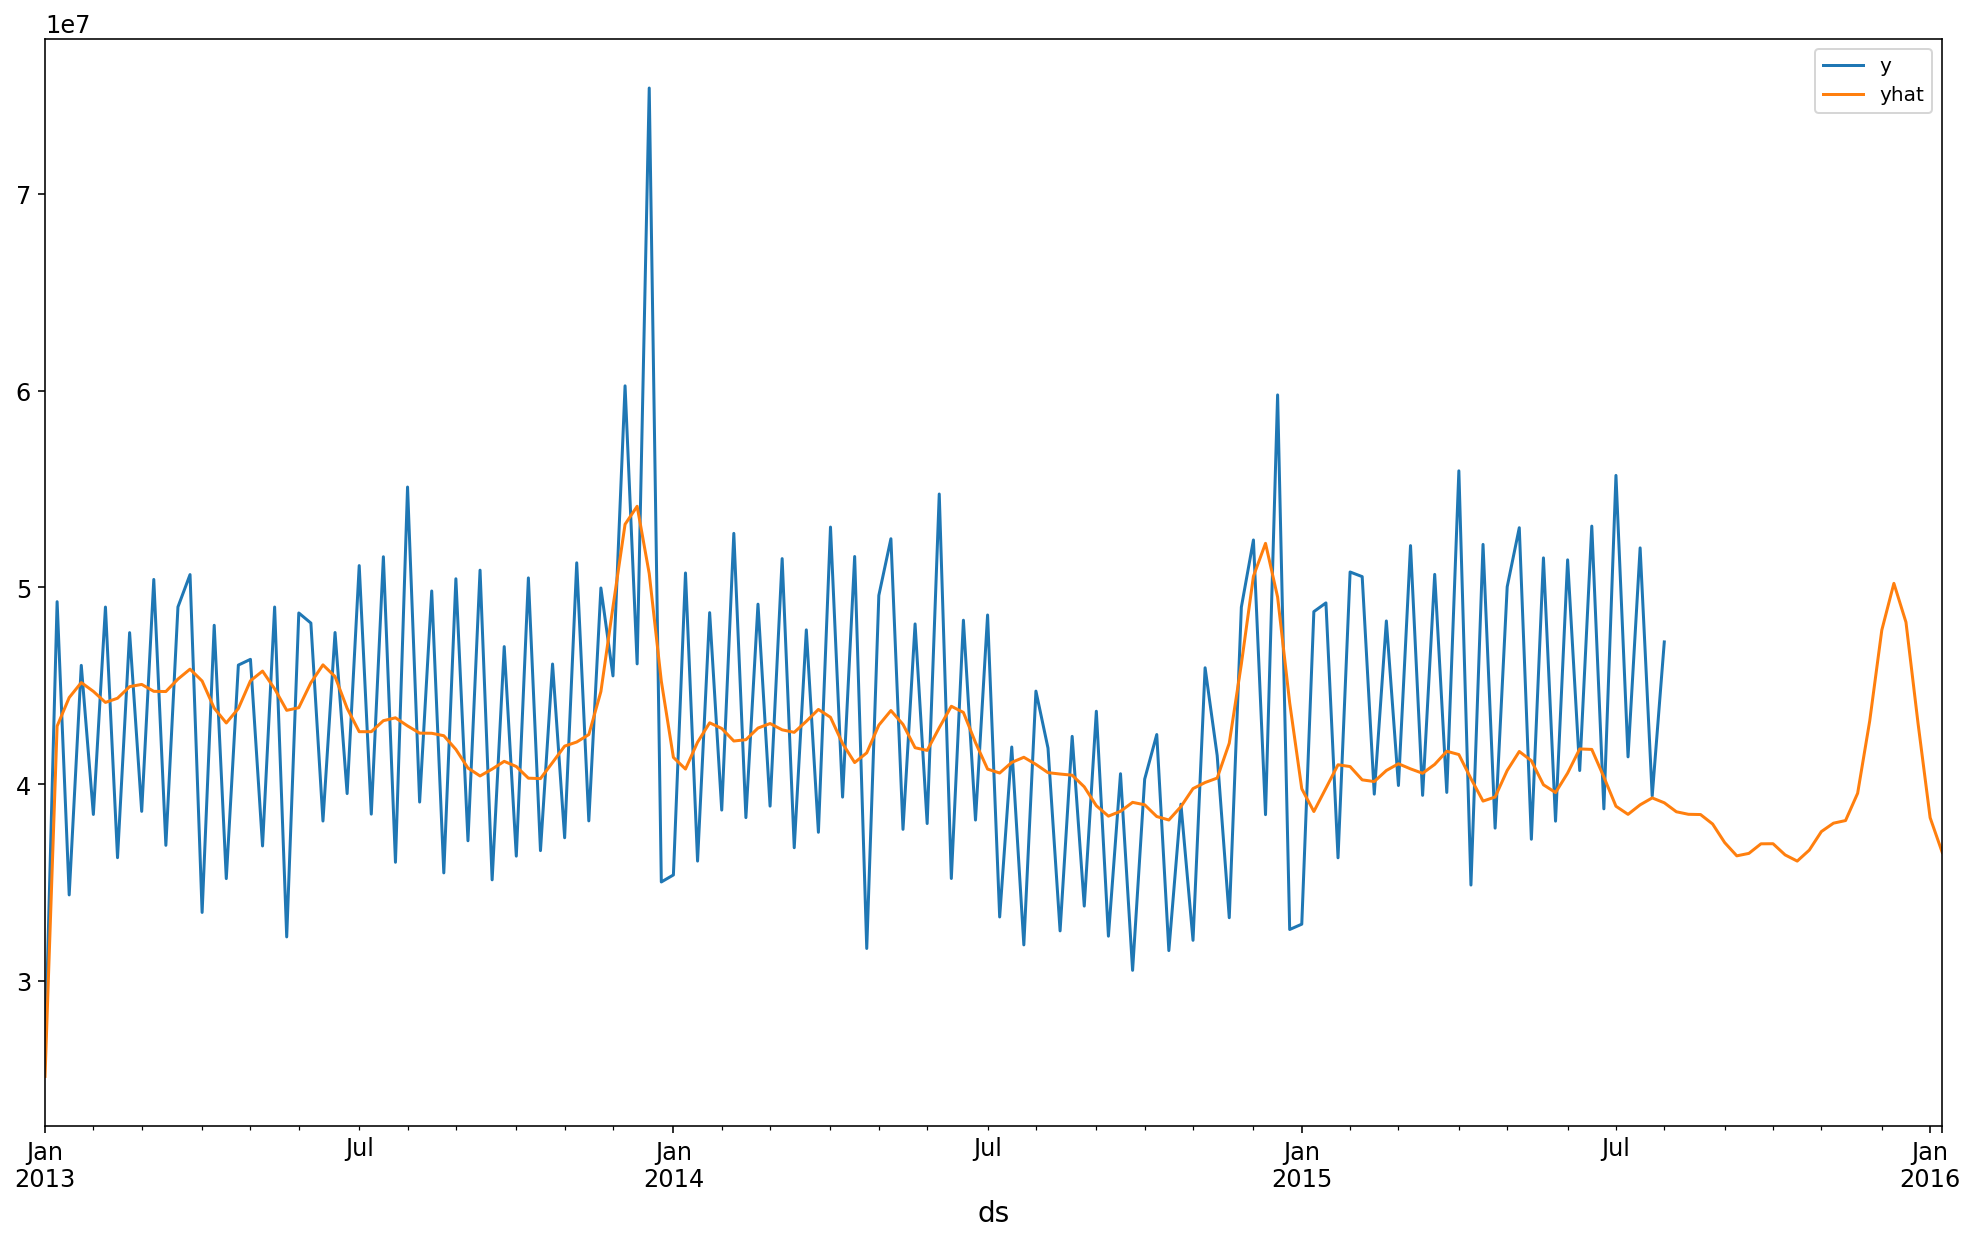

In [50]:
fc_week_prophet = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]] # create a df with only the importan variables
fc_week_prophet = fc_week_prophet.merge(ts_week_prophet, how = "left", on = "ds") #add the original data to the fc frame, so we can compare 
fc_week_prophet = fc_week_prophet.set_index("ds") # make a time series index

plt.figsize=(10,20)
fc_week_prophet["y"].plot(figsize=(17,10))
fc_week_prophet["yhat"].plot()

plt.legend()
plt.show()

**Random Forest Regression**

In [52]:
train_store_df["CompetitionOpenSince"] = np.where((train_store_df["CompetitionOpenSinceMonth"] == 0) & (train_store_df["CompetitionOpenSinceYear"] == 0), 
                                                0,(train_store_df.Month - train_store_df.CompetitionOpenSinceMonth) + (12 *(train_store_df.Year - train_store_df.CompetitionOpenSinceYear)))

# lets drop the variables
train_store_df = train_store_df.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)

In [53]:
# lets drop few variables, that either or not numeric or we dont need them anymore
# lets create a new data frame for this model
ts_rfr = train_store_df.copy()
ts_rfr = train_store_df.drop(["Date","StoreType", "Assortment", "PromoInterval", "CompetitionDistance_Cat"], axis = 1) #dop this columns, as we already have them in categories


In [54]:
from sklearn import model_selection
from sklearn import metrics

features = ts_rfr.drop(["Customers", "Sales", "Avg_Customer_Sales"], axis = 1)
target = ts_rfr["Sales"]

X_train, X_train_test, y_train, y_train_test = model_selection.train_test_split(features, target, test_size = 0.20, random_state = 15) 
# I call here train_test_set which is  divided 80% and 20% validation
print(X_train.shape, X_train_test.shape, y_train.shape, y_train_test.shape)

(675472, 17) (168868, 17) (675472,) (168868,)


In [55]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=10)
rfr.fit(X_train, y_train)
yhat = rfr.predict(X_train_test)
rms_rfr = sqrt(mean_squared_error(y_train_test, yhat))
print("RMS:", rms_rfr) 

RMS: 973.2649611784658


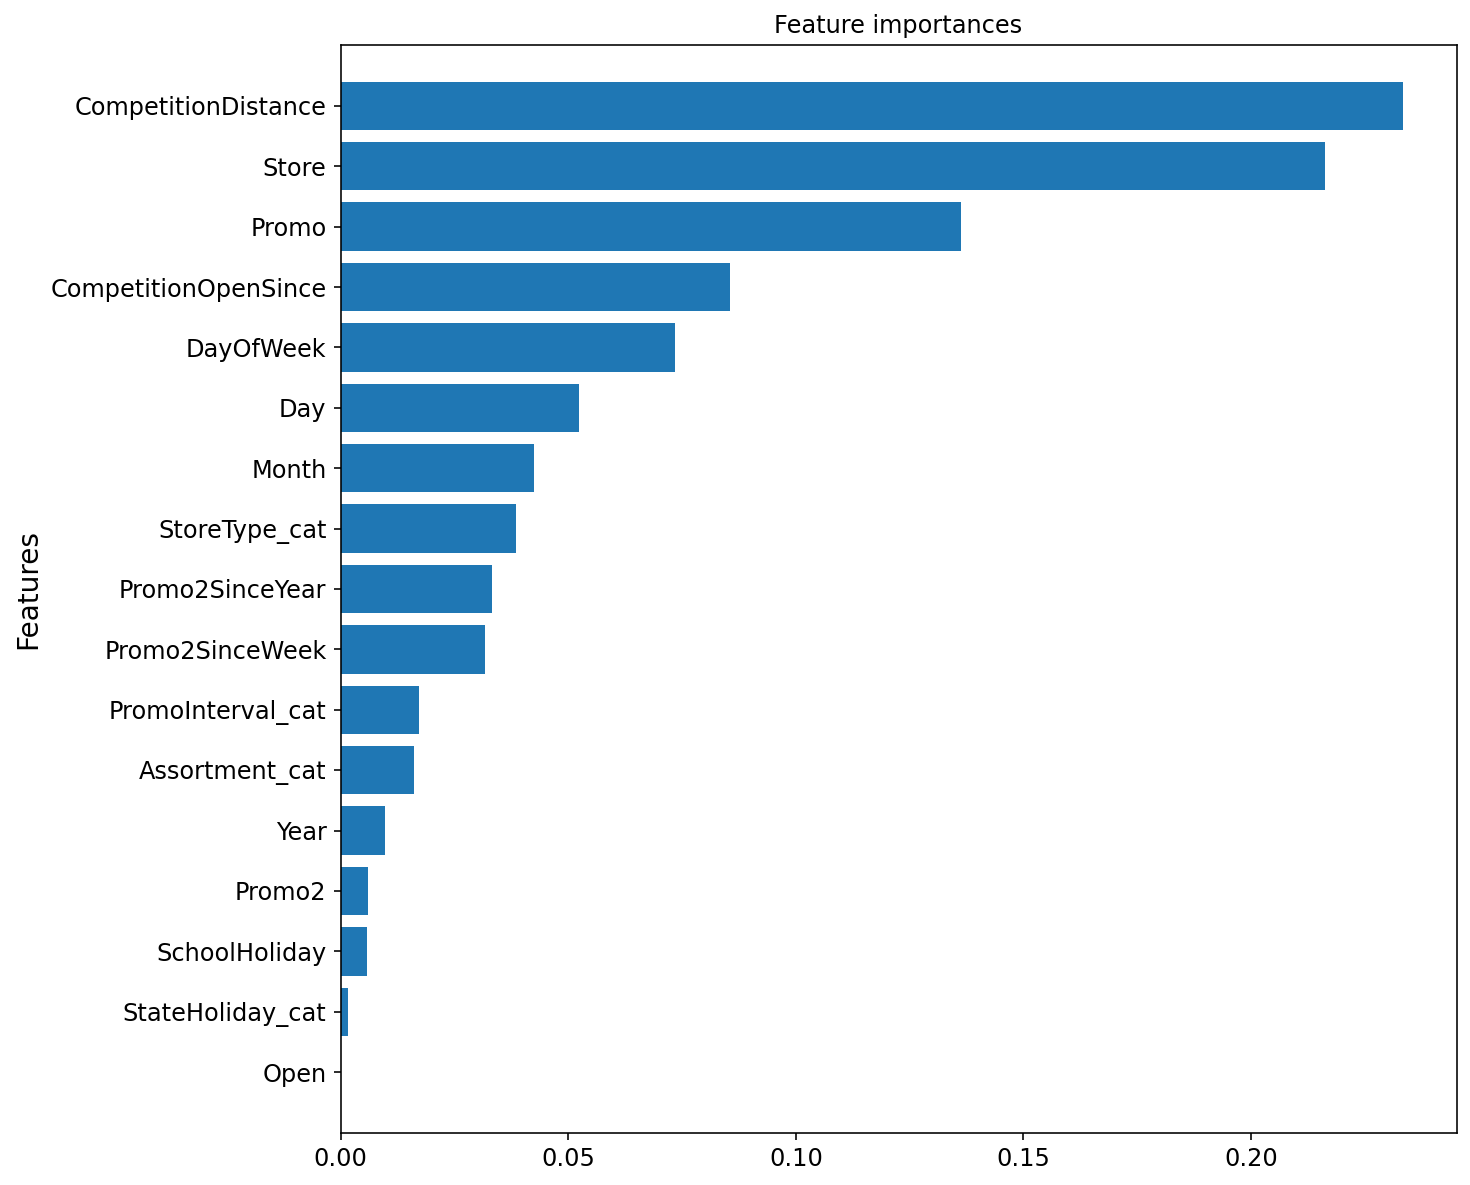

In [57]:
import itertools

importances = rfr.feature_importances_
std = np.std([rfr.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)
palette1 = itertools.cycle(sns.color_palette())
# Store the feature ranking
features_ranked=[]
for f in range(X_train.shape[1]):
    features_ranked.append(X_train.columns[indices[f]])
# Plot the feature importances of the forest

plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
            color=[next(palette1)], align="center")
plt.yticks(range(X_train.shape[1]), features_ranked)
plt.ylabel('Features')
plt.ylim([-1, X_train.shape[1]])
plt.show()

In [58]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [59]:
import xgboost as xgb

param = {'max_depth':10, # maximum depth of a tree
         "booster": "gbtree",   # use tree based models 
         'eta':1, # learning rate
         'silent':1, # silent mode
         'objective':'reg:linear', # for linear regression
#          "seed": 10,   # Random number seed
#          "subsample": 0.9,    # Subsample ratio of the training instances
        }

num_round = 100 #how many boosting rounds

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_train_test, y_train_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

xgboost = xgb.train(param, dtrain, num_round, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)
         
# make prediction
preds = xgboost.predict(dtest)

# model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
#   early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:2277.33	eval-rmse:2294.25	train-rmspe:nan	eval-rmspe:nan
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in expm1
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


[1]	train-rmse:2160.15	eval-rmse:2187.5	train-rmspe:nan	eval-rmspe:nan
[2]	train-rmse:1735.94	eval-rmse:1758.02	train-rmspe:nan	eval-rmspe:nan
[3]	train-rmse:1672.47	eval-rmse:1694.27	train-rmspe:nan	eval-rmspe:nan
[4]	train-rmse:1559.28	eval-rmse:1586.06	train-rmspe:nan	eval-rmspe:nan
[5]	train-rmse:1476.44	eval-rmse:1507.67	train-rmspe:nan	eval-rmspe:nan
[6]	train-rmse:1304.68	eval-rmse:1340.2	train-rmspe:nan	eval-rmspe:nan
[7]	train-rmse:1253.03	eval-rmse:1296.6	train-rmspe:nan	eval-rmspe:nan
[8]	train-rmse:1197.63	eval-rmse:1242.58	train-rmspe:nan	eval-rmspe:nan
[9]	train-rmse:1154.74	eval-rmse:1203.24	train-rmspe:nan	eval-rmspe:nan
[10]	train-rmse:1115.54	eval-rmse:1167.81	train-rmspe:nan	eval-rmspe:nan
[11]	train-rmse:1087.84	eval-rmse:1144.12	train-rmspe:nan	eval-rmspe:nan
[12]	train-rmse:1073.59	eval-rmse:1132.31	train-rmspe:nan	eval-rmspe:nan
[13]	train-rmse:1045.45	eval-rmse:1108.08	train-rmspe:nan	eval-rmspe:nan
[14]	train-rmse:1022.33	eval-rmse:1087.02	train-rmspe:nan	eval-

In [60]:
rms_xgboost = sqrt(mean_squared_error(y_train_test, preds))
print("RMS:", rms_xgboost) 

RMS: 867.4677909019265


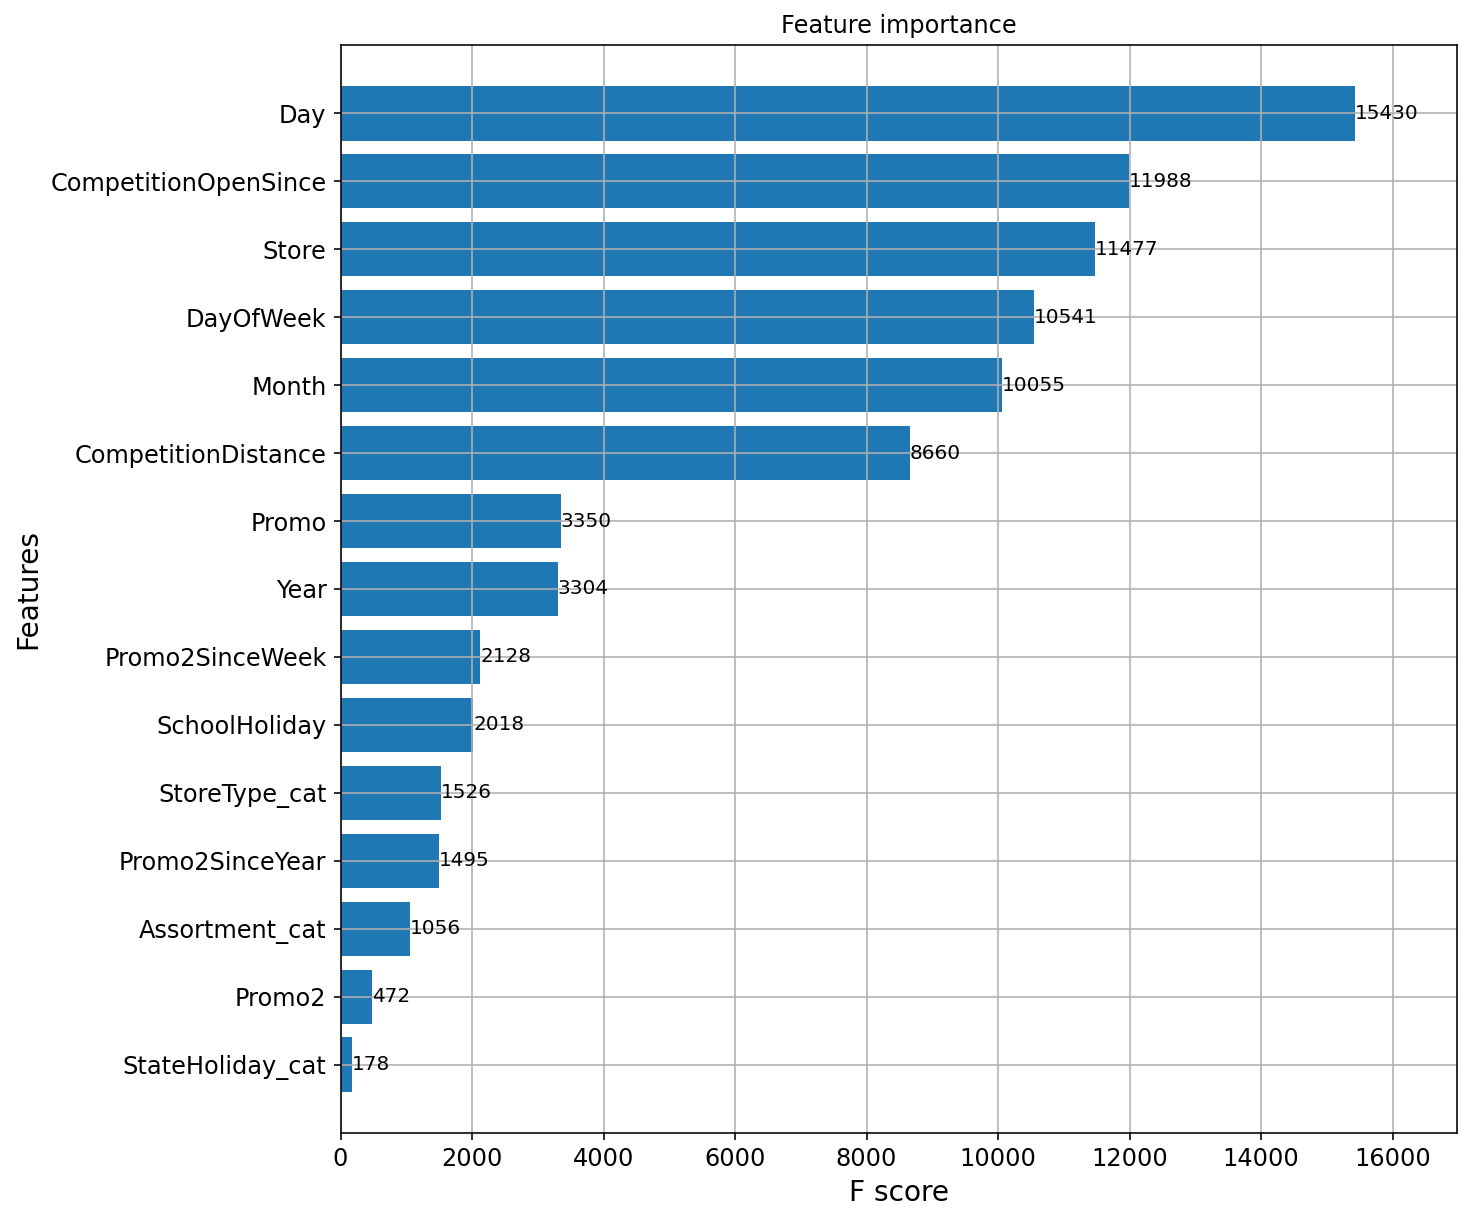

In [61]:
# Lets see the feature importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgboost, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [62]:
print("now lets see the scores togher")

model_errors = pd.DataFrame({
    "Model": ["Random Forest Regression", "XGBoost"],
    "Score": [rms_rfr, rms_xgboost]
})

model_errors.sort_values(by = "Score", ascending = True)

now lets see the scores togher


,Model,Score
1,XGBoost,867.467791
0,Random Forest Regression,973.264961
